# Random Forest Classification with Biased Datasets

## Obiettivo

L’obiettivo di questa tesi triennale è analizzare il fenomeno del bias nei modelli di Machine Learning, in particolare nel Random Forest. Per far questo utilizzeremo una derivazione del dataset MNIST in cui per ogni numero è associato un colore. In particolare utilizzeremo un dataset in cui il 95% delle immagini per ciascuna cifra presenta il colore corretto (anche detti *biased aligned*), mentre il restante 5% ha un colore associato a un’altra cifra (anche detti *biased conflicting*). Pertanto il nostro obiettivo sarà quello di studiare le performance del modello Random Forest sulle immagini *biased aligned* e le performance su quelle *biased conflicting*, analizzando i risultati per ciascuna classe.

In una seconda fase, prenderemo le features estratte da una rete neurale pre-allenata sul dataset CMNIST e poi le features estratte da una rete pre-allenata su ImageNet. Utilizzeremo questi valori per analizzare il bias del Random Forest sullo stessa informazione ma con una rappresentazione di dato diversa.

Nella fase di testing, ci occuperemo di calcolare l'accuracy dei nostri modelli su tre campioni distinti:
1. **Campione generale:** insieme di immagini/features contenente numeri biased aligned o biased conflicting.
2. **Campione biased aligned:** insieme di immagini/features biased aligned, ovvero immagini il cui colore è corretto rispetto all'etichetta di classe.
3. **Campione biased conflicting:** insieme di immagini/features biased conflicting, ovvero immagini il cui colore è diverso rispetto all'etichetta di classe.

L'accuratezza del modello viene calcolata confrontando le predizioni del modello con le etichette reali su un set di dati di test, ovvero ogni albero della foresta produce una predizione indipendente e la predizione finale per ogni istanza è ottenuta tramite voto di maggioranza.

**Nota:** le features di una rete neurale non corrispondono più ai pixel di un'immagine ma corrisponderanno a delle caratteristiche imparate (in qualche modo) dalla rete neurale.

## Imports

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Funzioni utili

In questa sezione saranno presenti alcune funzioni usate svariate volte nel corso del notebook. La prima funzione che andremo a definire sarà la funzione che ci permetterà di fare il tuning del numero corretto di estimatori del Random Forest, dato in input il dataset. In particolare misureremo l'accuracy sul dataset di validation contenente sia biased aligned che biased conflicting:

In [2]:
def find_num_estimators(X_train, Y_train, X_valid, Y_valid):
    estimator_range = [50, 100, 150, 200, 250, 300]
    validation_accuracies = []
    
    print("Starting n_estimators tuning...")
    for n_est in estimator_range:
        model_test = RandomForestClassifier(n_estimators=n_est, random_state=42, n_jobs=-1) # Use n_jobs=-1 to use all processors
        print(f"Training with {n_est} estimators...")
        model_test.fit(X_train, Y_train)
        y_valid_pred = model_test.predict(X_valid)
        accuracy = accuracy_score(Y_valid, y_valid_pred)
        validation_accuracies.append(accuracy)
        print(f"Validation Accuracy for {n_est} estimators: {accuracy:.4f}")
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.plot(estimator_range, validation_accuracies, marker='o', linestyle='-')
    plt.title('Random Forest Validation Accuracy vs. Number of Estimators')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Validation Accuracy')
    plt.xticks(estimator_range)
    plt.grid(True)
    plt.show()
    
    best_n_estimators = estimator_range[np.argmax(validation_accuracies)]
    print(f"Best n_estimators from this test: {best_n_estimators} with accuracy: {max(validation_accuracies):.4f}")

Un'altra funzione che andremo a definire sarà quella che ci permetterà di visualizzare la confusion matrix dei valori predetti per gli oggetti biased aligned e biased conflicting, aiutandoci nella visualizzazione e nell'analisi delle performance dle nostro modello:

In [3]:
def print_confusion_matrix(Y_test, Y_test_bias, y_pred):
    # Identifica gli indici dei campioni aligned e conflicting
    aligned_idx = np.where(Y_test == Y_test_bias)[0]
    conflicting_idx = np.where(Y_test != Y_test_bias)[0]
    
    # Crea una figura con due sottoplot affiancati
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Confusion matrix per i campioni aligned
    ConfusionMatrixDisplay.from_predictions(
        Y_test[aligned_idx],
        y_pred[aligned_idx],
        normalize='true',
        ax=axes[0],
        colorbar=False
    )
    axes[0].set_title("Confusion Matrix - Aligned")
    
    # Confusion matrix per i campioni conflicting
    ConfusionMatrixDisplay.from_predictions(
        Y_test[conflicting_idx],
        y_pred[conflicting_idx],
        normalize='true',
        ax=axes[1],
        colorbar=False
    )
    axes[1].set_title("Confusion Matrix - Conflicting")
    
    plt.tight_layout()
    plt.show()

## Importazione dataset CMNIST

Prima di importare il dataset abbiamo bisogno di definire in modo chiaro il tipo di dato su cui andremo a lavorare. Il dataset CMNIST è composto da immagini, pertano utilizzeremo la libreria *opencv* per andare a leggere ciascuna immagine che sarà di dimensione 28x28x3, dove 28x28 sono il numero di pixel e 3 sono i canali RGB di ciascuna immagine. 

Dal momento che il modello Random Forest lavora esclusivamente su istanze descritte da vettori e non da matrici, avremo bisogno di eseguire il *flatten* su ciascuna immagine così da avere un vettore 2352x1. Eseguendo questa operazione su ciascuna immagine otterremo il nostro input per il Random Forest. 

Per quanto riguarda i valori di output (e quindi la classificazione prodotta dal nostro modello), avremo bisogno di due liste:
- Y: corrisponde alle etichette di classe dell'oggetto di input (per esempio se l'immagine è uno 0, nella Y vi sarà uno 0)
- Y_bias: descrive la presenza o assenza di bias per ciascun oggetto di input, in particolare conterrà il valore relativo al colore assunto da quel numero.

Per definire tali liste andremo ad analizzare il nome del file di ciascuna immagine, il quale formate è il seguente "x_y_z.png", dove:
- x: è l'identificativo dell'immagine
- y: è l'etichetta di classe dell'immagine
- z: è il bias dell'immagine

Di conseguenza Y sarà composta dalla *y* di ciascuna immagine e Y_bias sarà composta dalla *z* di ciascuna immagine.

Infine, le directory del nostro dataset sono già strutturate in modo ottimo tra dataset di training, validation e testing, pertanto non avremo bisogno di dividere "manualmente" questi insiemi ma dovremo solamente leggere le cartelle giuste.

### Funzione per la lettura delle immagini

Per convenienza andremo a definire una funzione che possa essere chiamata su una cartella e restituisca rispettivamente X, Y e Y_bias:

In [4]:
def load_images_bias(folder_path):
    X = []
    Y = []
    Y_bias = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(img.flatten())

        parts = filename.split('_')
        y = int(parts[1])
        y_bias = int(parts[2].split('.')[0])
        Y.append(y)
        Y_bias.append(y_bias)

    return np.array(X), np.array(Y), np.array(Y_bias)

Inoltre definiamo una funzione che calcoli il numero totale di immagini nelle cartelle visionate, in modo da controllare se tutte le immagini sono state importate correttamente:

In [5]:
def count_total_images(folder_path):
    return len([f for f in os.listdir(folder_path)])

### Definizione dataset di training

A questo punto andiamo a definire il dataset di training che conterrà tutte le immagini nelle cartelle *align* e *conflict*:

In [6]:
X_train = []
Y_train = []
Y_train_bias = []

In [7]:
total_images = 0
folder_path = 'cmnist/5pct/'
numbers = [str(i) + "/" for i in range(10)]

for parent_folder in ['align/', 'conflict/']:
    for number in numbers:
        X_batch, Y_batch, Y_bias_batch = load_images_bias(folder_path + parent_folder + number)
        X_train.extend(X_batch)        
        Y_train.extend(Y_batch)
        Y_train_bias.extend(Y_bias_batch)
        total_images += count_total_images(folder_path + parent_folder + number)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train_bias = np.array(Y_train_bias)

Ora mostriamo le dimensioni di ciascun insieme in modo da essere sicuri di aver importato correttamente l'insieme di training:

In [8]:
print(f"Total images       = {total_images}")
print(f"X_train shape      = {X_train.shape}")
print(f"Y_train shape      = {Y_train.shape}")
print(f"Y_train_bias shape = {Y_train_bias.shape}")

Total images       = 55000
X_train shape      = (55000, 2352)
Y_train shape      = (55000,)
Y_train_bias shape = (55000,)


### Definizione dataset di validation

A questo punto andiamo a definire il dataset di validation che conterrà tutte le immagini nella cartella "valid":

In [9]:
X_valid = []
Y_valid = []
Y_valid_bias = []

In [10]:
total_images = 0
folder_path = 'cmnist/5pct/valid/'

X_batch, Y_batch, Y_bias_batch = load_images_bias(folder_path)
X_valid.extend(X_batch)        
Y_valid.extend(Y_batch)
Y_valid_bias.extend(Y_bias_batch)
total_images = count_total_images(folder_path)

X_valid = np.array(X_valid)
Y_valid = np.array(Y_valid)
Y_valid_bias = np.array(Y_valid_bias)

Ora mostriamo le dimensioni di ciascun insieme in modo da essere sicuri di aver importato correttamente l'insieme di validation:

In [11]:
print(f"Total images       = {total_images}")
print(f"X_valid shape      = {X_valid.shape}")
print(f"Y_valid shape      = {Y_valid.shape}")
print(f"Y_valid_bias shape = {Y_valid_bias.shape}")

Total images       = 5000
X_valid shape      = (5000, 2352)
Y_valid shape      = (5000,)
Y_valid_bias shape = (5000,)


### Definizione dataset di testing

Infine andiamo a definire il dataset di testing che conterrà tutte le immagini nella cartella "test".

**Nota:** dal momento che il nostro dataset è composto da diversi valori di correlazione, la cartella "test" si trova in un folder path diverso rispetto alle precedenti cartelle.

In [12]:
X_test = []
Y_test = []
Y_test_bias = []

In [13]:
total_images = 0
folder_path = 'cmnist/test/'

for number in numbers:
    X_batch, Y_batch, Y_bias_batch = load_images_bias(folder_path + number)
    X_test.extend(X_batch)        
    Y_test.extend(Y_batch)
    Y_test_bias.extend(Y_bias_batch)
    total_images += count_total_images(folder_path + number)

X_test = np.array(X_test)
Y_test = np.array(Y_test)
Y_test_bias = np.array(Y_test_bias)

Ora mostriamo le dimensioni di ciascun insieme in modo da essere sicuri di aver importato correttamente l'insieme di testing:

In [14]:
print(f"Total images       = {total_images}")
print(f"X_test shape      = {X_test.shape}")
print(f"Y_test shape      = {Y_test.shape}")
print(f"Y_test_bias shape = {Y_test_bias.shape}")

Total images       = 10000
X_test shape      = (10000, 2352)
Y_test shape      = (10000,)
Y_test_bias shape = (10000,)


### Visualizzazione dataset

In questa sezione mostriamo una breve visualizzazione del dataset, mostrando le caratteristiche delle immagini aligned o conflicting. Iniziamo visualizzando il nostro dataset di training. Mostreremo come prima immagine l'immagine aligned di ogni numero, mentre le restanti immagini di ciascuna riga saranno *conflicting* rispetto a quel numero:

In [15]:
img_shape = (28, 28, 3)

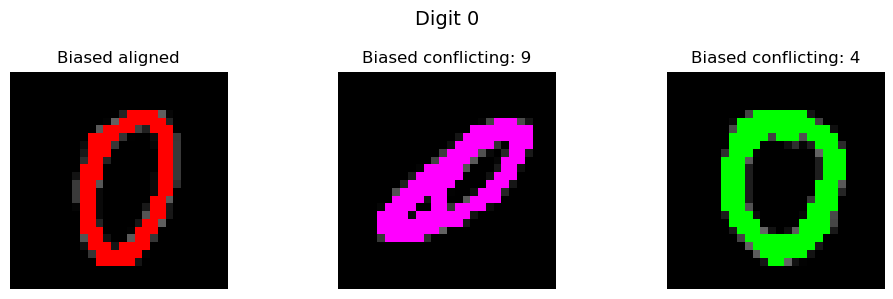

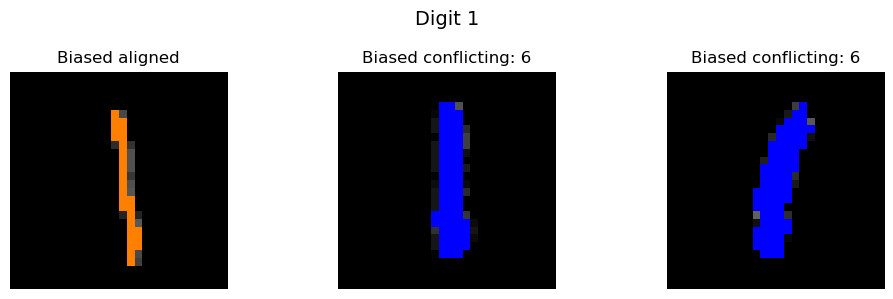

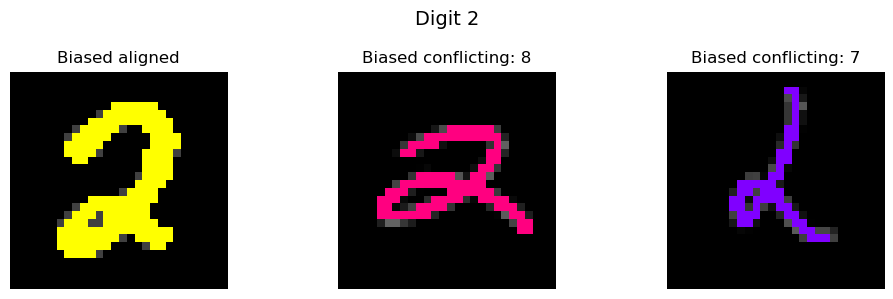

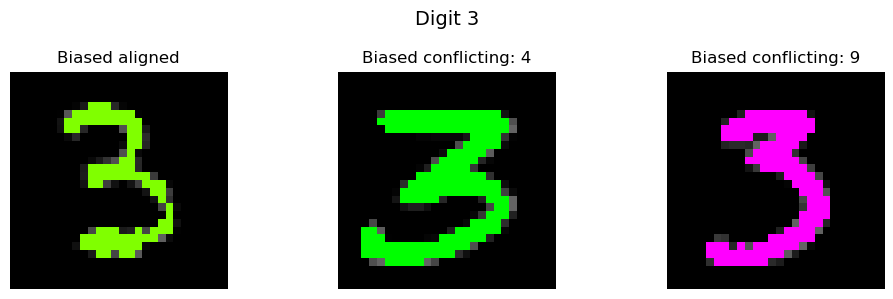

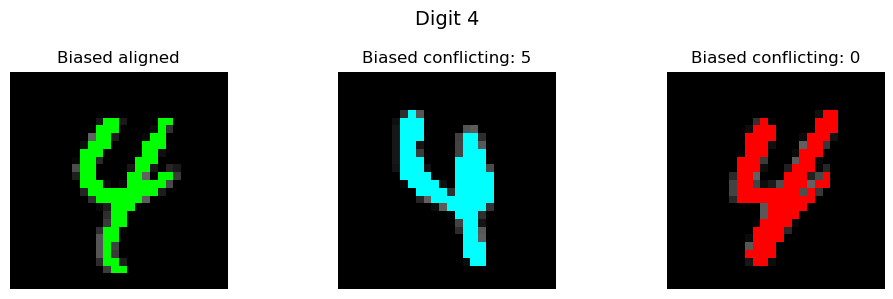

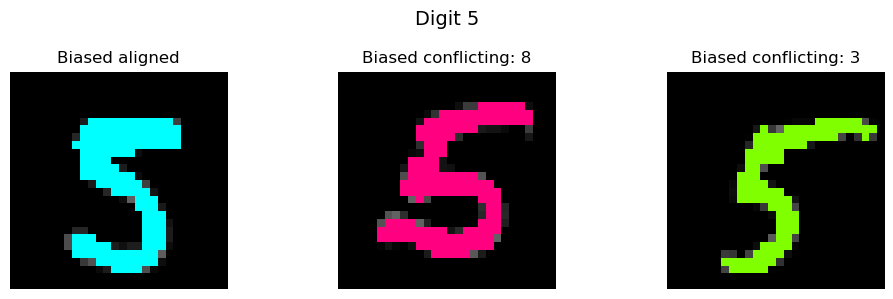

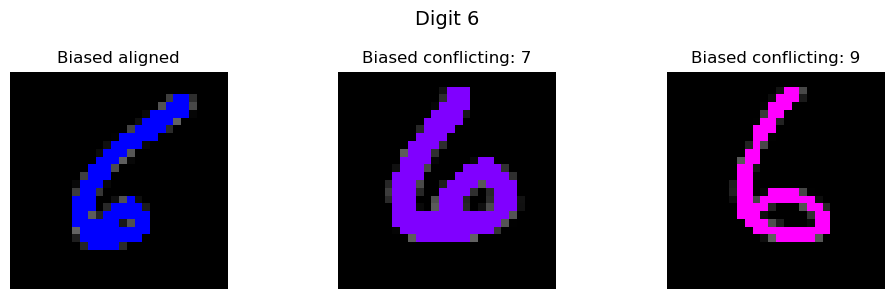

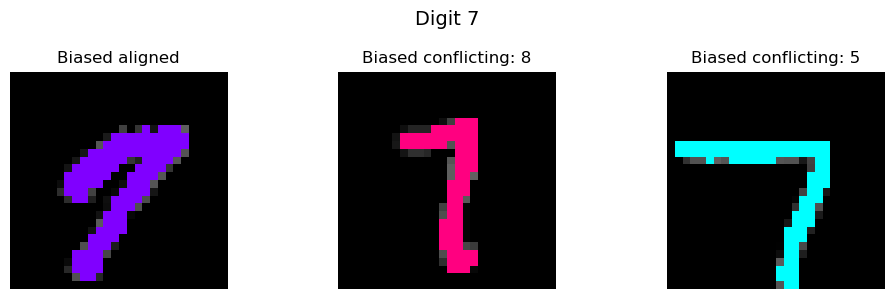

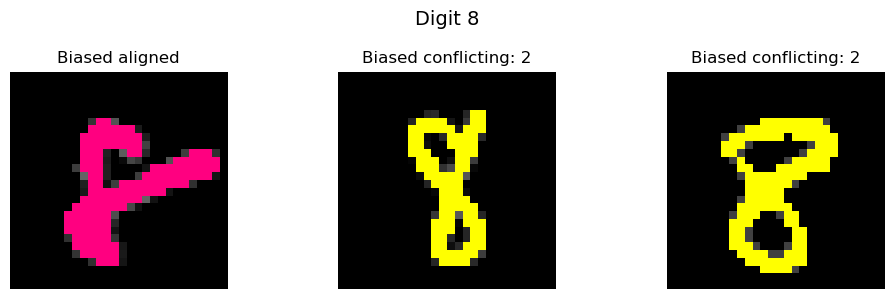

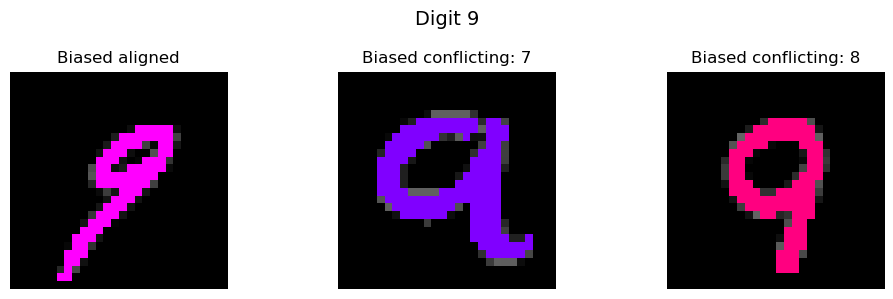

In [16]:
for digit in range(10):
    unbiased_idx = np.where((Y_train == digit) & (Y_train_bias == digit))[0]
    biased_idx = np.where((Y_train == digit) & (Y_train_bias != digit))[0]

    selected_indices = [unbiased_idx[0]] + list(biased_idx[:2])

    plt.figure(figsize=(10, 3))
    for i, idx in enumerate(selected_indices):
        img = X_train[idx].reshape(img_shape)
        plt.subplot(1, 3, i + 1)
        plt.imshow(img.astype(np.uint8))
        title = "Biased aligned" if i == 0 else f"Biased conflicting: {Y_train_bias[idx]}"
        plt.title(title)
        plt.axis('off')

    plt.suptitle(f"Digit {digit}", fontsize=14)
    plt.tight_layout()
    plt.show()

Invece per quanto riguarda il validation set e il training set, mostriamo 10 immagini per ciascun insieme: 

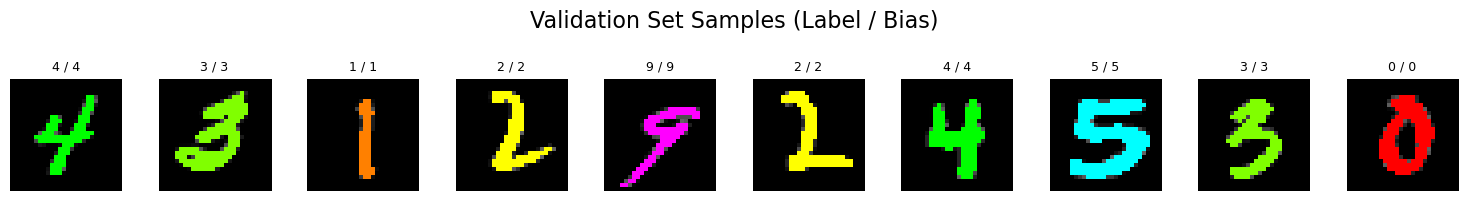

In [17]:
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle("Validation Set Samples (Label / Bias)", fontsize=16)

random_indices = np.random.randint(0, X_valid.shape[0], size=10)

for plot_idx, img_idx in enumerate(random_indices):
    ax = axes[plot_idx]
    img = X_valid[img_idx].reshape(img_shape)
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f"{Y_valid[img_idx]} / {Y_valid_bias[img_idx]}", fontsize=9)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

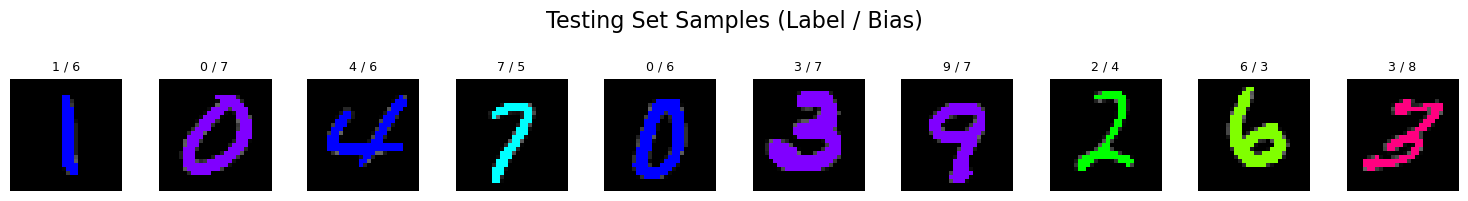

In [18]:
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle("Testing Set Samples (Label / Bias)", fontsize=16)

random_indices = np.random.randint(0, X_test.shape[0], size=10)

for plot_idx, img_idx in enumerate(random_indices):
    ax = axes[plot_idx]
    img = X_test[img_idx].reshape(img_shape)
    ax.imshow(img.astype(np.uint8))
    ax.set_title(f"{Y_test[img_idx]} / {Y_test_bias[img_idx]}", fontsize=9)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

## Random Forest allenato con dataset CMNIST

Random Forest è un metodo di apprendimento ensemble, che combina più alberi decisionali per ottenere un modello complessivo più stabile rispetto ai singoli alberi.

Al posto di far affidamento ad un solo albero decisionale (che solitamente è soggetto all'overfitting), un Random Forest costruisce una foresta di alberi. Ciascun di questi alberi viene addestrato su un sottoinsieme casuale del dataset di training, selezionato mediante la tecnica del bootstrap (campionamento con ripetizione, alcune istanze possono essere visionate più volte mentre altre mai). Ogni nodo dell'albero considera solo un sottoinsieme casuale delle caratteristiche disponibili per decidere la partizione ottimale. Questa casualità introduce varietà tra gli alberi e riduce la correlazione tra di essi, migliorando la generalizzazione.

### Inizializzazione e Training

Procediamo a definire il modello con iper-parametri, al momento, generici:

In [19]:
model = RandomForestClassifier(n_estimators=100, random_state=42)

Successivamente andiamo ad allenarlo con il dataset di training definito nella sezione precedente:

In [20]:
model.fit(X_train, Y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Validation

In questa sezione, attraverso il dataset di validation, andremo a definire in numero di estimatori definito al fine di ottenere il miglior risultati di precisione possibili.

**Nota:** gli altri iper-parametri per il modello Random Forest non verranno testati.

Starting n_estimators tuning...
Training with 50 estimators...
Validation Accuracy for 50 estimators: 0.9690
Training with 100 estimators...
Validation Accuracy for 100 estimators: 0.9676
Training with 150 estimators...
Validation Accuracy for 150 estimators: 0.9684
Training with 200 estimators...
Validation Accuracy for 200 estimators: 0.9678
Training with 250 estimators...
Validation Accuracy for 250 estimators: 0.9682
Training with 300 estimators...
Validation Accuracy for 300 estimators: 0.9684


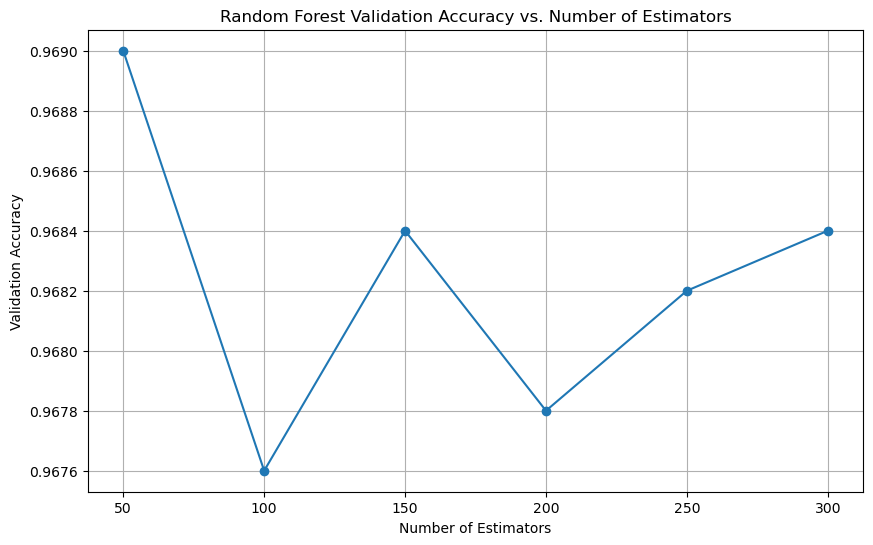

Best n_estimators from this test: 50 with accuracy: 0.9690


In [21]:
find_num_estimators(X_train, Y_train, X_valid, Y_valid)

Osserviamo come il numero di estimatori, nel dataset di validation, non influenza in maniera significativa le performance del nostro modello. Pertanto continueremo ad utilizzare il modello con 100 estimatori.

### Testing

Seguendo quanto descritto nella sezione iniziale degli obiettivi, per testare le performance andiamo a definire i due nuovi insiemi di testing, rispettivamente il campione con solo immagini biased aligned e poi il campione con solo immagini biased conflicting:

In [22]:
# Biased aligned sample
X_test_aligned = X_test[Y_test == Y_test_bias]
Y_test_aligned = Y_test[Y_test == Y_test_bias]
Y_test_bias_aligned = Y_test_bias[Y_test == Y_test_bias]

In [23]:
# Biased conflicting sample
X_test_conflicting = X_test[Y_test != Y_test_bias]
Y_test_conflicting = Y_test[Y_test != Y_test_bias]
Y_test_bias_conflicting = Y_test_bias[Y_test != Y_test_bias]

A questo punto misuriamo l'accuracy del nostro modello sui tre campioni definiti precedentemente e analizziamo i risultati:

In [24]:
# General sample
y_pred = model.predict(X_test)

In [25]:
# Biased aligned sample
y_pred_aligned = model.predict(X_test_aligned)

In [26]:
# Biased conflicting sample
y_pred_conflicting = model.predict(X_test_conflicting)

In [27]:
print(f"Accuracy on general sample: {accuracy_score(Y_test, y_pred):.5f}")
print(f"Accuracy on biased aligned sample: {accuracy_score(Y_test_aligned, y_pred_aligned):.5f}")
print(f"Accuracy on biased conflicting sample: {accuracy_score(Y_test_conflicting, y_pred_conflicting):.5f}")

Accuracy on general sample: 0.41300
Accuracy on biased aligned sample: 1.00000
Accuracy on biased conflicting sample: 0.34734


Possiamo osservare come il nostro modello sia estremamente influenzato dal bias del colore. Infatti, per tutte le immagini biased aligned la sua predizione sarà corretta (100% accuracy), questo suggerisce che il modello ha imparato ad associare fortemente il colore alla classe, cioè ha imparato il bias del dataset piuttosto che la forma reale della cifra. Mentre per le immagini biased conflicting la sua accuracy cala drasticamente, arrivando ad un 34% di predizione corretta nella classificazione delle immagini.

Per quanto riguarda l'accuracy generale, essa è abbastanza bassa, arrivando ad un 41% di precisione della classificazione. Questo può essere un indice di una difficoltà a generalizzare correttamente su dati con un bias.

In conclusione possiamo dire che il modello Random Forest ha fortemente imparato il bias del colore, piuttosto che le caratteristiche strutturali delle cifre.

Un'analisi più dettagliata può essere svolta con l'utilizzo di *classification_report* il quale indica:
- Precision: di tutte i numeri che il modello che ha classificato come appartenenti ad una determinata classe, quante lo erano veramente?
- Recall: di tutte i numeri che erano veramente di questa classe, quante il modello è riuscito ad identificare correttamente?
- F1-score: è la media armonica della precisione e della recall.
- Support: è il numero di numeri di quella classe nel set di dati su cui è stato calcolato il report.

In [28]:
print("\nClassification Report on general sample:\n", classification_report(Y_test, y_pred))


Classification Report on general sample:
               precision    recall  f1-score   support

           0       0.59      0.63      0.61       980
           1       0.76      0.74      0.75      1135
           2       0.33      0.34      0.33      1032
           3       0.33      0.35      0.34      1010
           4       0.32      0.30      0.31       982
           5       0.18      0.18      0.18       892
           6       0.41      0.39      0.40       958
           7       0.54      0.55      0.54      1028
           8       0.23      0.22      0.23       974
           9       0.34      0.35      0.35      1009

    accuracy                           0.41     10000
   macro avg       0.40      0.41      0.40     10000
weighted avg       0.41      0.41      0.41     10000



In [29]:
print("\nClassification Report on biased aligned sample:\n", classification_report(Y_test_aligned, y_pred_aligned))


Classification Report on biased aligned sample:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00       108
           2       1.00      1.00      1.00       118
           3       1.00      1.00      1.00       107
           4       1.00      1.00      1.00       104
           5       1.00      1.00      1.00        74
           6       1.00      1.00      1.00        96
           7       1.00      1.00      1.00       113
           8       1.00      1.00      1.00        94
           9       1.00      1.00      1.00       100

    accuracy                           1.00      1006
   macro avg       1.00      1.00      1.00      1006
weighted avg       1.00      1.00      1.00      1006



In [30]:
print("\nClassification Report on biased conflicting sample:\n", classification_report(Y_test_conflicting, y_pred_conflicting))


Classification Report on biased conflicting sample:
               precision    recall  f1-score   support

           0       0.55      0.59      0.57       888
           1       0.74      0.71      0.73      1027
           2       0.25      0.25      0.25       914
           3       0.26      0.27      0.27       903
           4       0.24      0.22      0.23       878
           5       0.11      0.10      0.11       818
           6       0.34      0.32      0.33       862
           7       0.48      0.50      0.49       915
           8       0.14      0.14      0.14       880
           9       0.27      0.28      0.28       909

    accuracy                           0.35      8994
   macro avg       0.34      0.34      0.34      8994
weighted avg       0.35      0.35      0.35      8994



### Visualizzazione errori

Di seguito mostreremo alcune predizioni errate da parte del nostro modello per accentuare l'osservazione fatta in precedenza, ovvero che il modello ha imparato il colore e non la forma del numero.

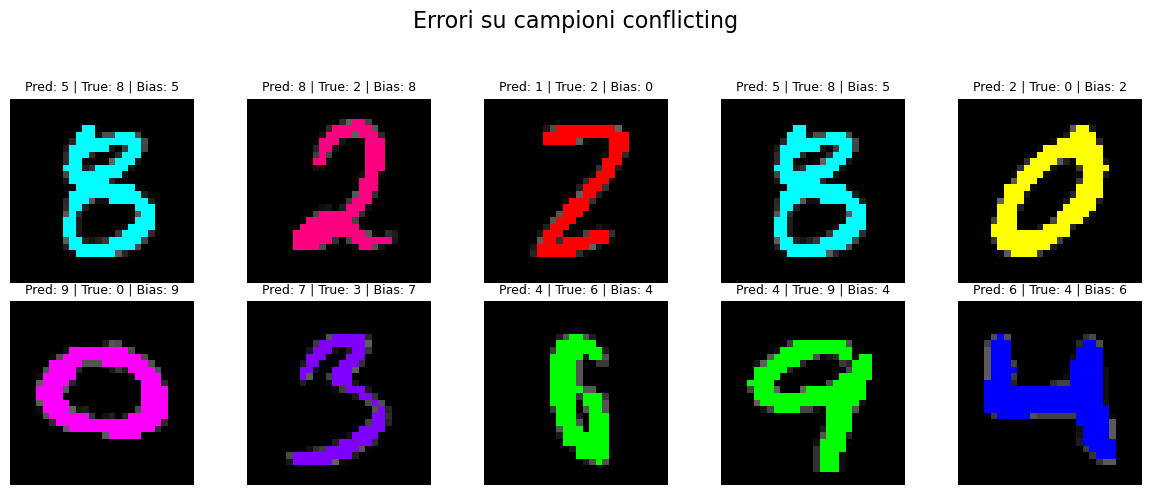

In [31]:
wrong_idx = np.where((y_pred != Y_test) & (Y_test != Y_test_bias))[0]

selected_indices = wrong_idx[np.random.randint(0, len(wrong_idx), size=10)]

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Errori su campioni conflicting", fontsize=16)

for i, idx in enumerate(selected_indices):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    
    img = X_test[idx].reshape(img_shape).astype(np.uint8)
    ax.imshow(img)
    ax.set_title(f"Pred: {y_pred[idx]} | True: {Y_test[idx]} | Bias: {Y_test_bias[idx]}", fontsize=9)
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

Infine mostriamo la diffusion matrix per le predizioni del campione biased aligned e del campione biased conflicting:

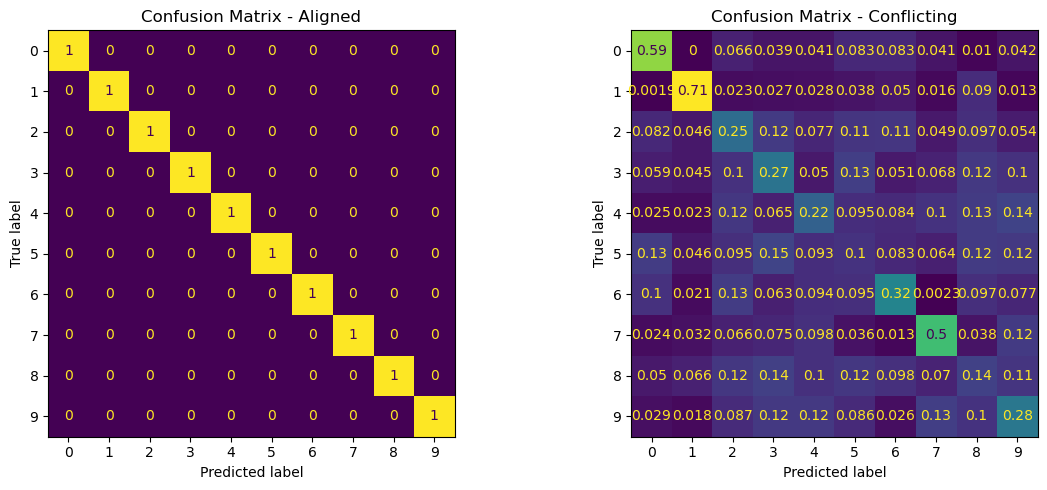

In [32]:
print_confusion_matrix(Y_test, Y_test_bias, y_pred)

Dalla *confusion matrix* possiamo osservare che il modello ha il 100% di accuracy per ogni numero biased aligned (matrice di sinistra), mentre per quanto riguarda i numeri biased conflicting la sua precisione è bassa risultando in una matrice densa (matrice di destra). 

### Performance Random Forest su dataset bilanciato

Per avere una conferma delle nostre ipotesi, in questa sezione procederemo a definire un dataset di training bilanciato, ovvero con un numero di immagini biased aligned uguali a quelle biased conflicting. Infatti, per ora abbiamo la seguente proporzione tra immagini biased aligned e quelle conflicting nel dataset di training:

In [33]:
print(f"Immagini biased aligned: {len(Y_train_bias[Y_train == Y_train_bias])}/{len(Y_train_bias)}")
print(f"Immagini biased conflicting: {len(Y_train_bias[Y_train != Y_train_bias])}/{len(Y_train_bias)}")

Immagini biased aligned: 52551/55000
Immagini biased conflicting: 2449/55000


Pertanto procediamo a definire il nuovo dataset che conterrà tutte le immagini biased conflicting a nostra disposizione e un numero di immagini biased aligned pari a quelle conflicting:

In [34]:
dim = len(Y_train_bias[Y_train != Y_train_bias])
aligned_indices = []
conflicting_indices = []

for i in range(len(Y_train)):
    if len(aligned_indices) >= dim and len(conflicting_indices) >= dim:
        break  
    if Y_train[i] == Y_train_bias[i]:
        if len(aligned_indices) < dim:
            aligned_indices.append(i)
    else:
        if len(conflicting_indices) < dim:
            conflicting_indices.append(i)

In [35]:
X_train_balanced = X_train[aligned_indices + conflicting_indices]
Y_train_balanced = Y_train[aligned_indices + conflicting_indices]
Y_train_bias_balanced = Y_train_bias[aligned_indices + conflicting_indices]

A questo punto controlliamo se le dimensioni del dataset sono quelle attese:

In [36]:
print(f"Immagini biased aligned: {len(X_train_balanced[Y_train_balanced == Y_train_bias_balanced])}/{len(X_train_balanced)}")
print(f"Immagini biased conflicting: {len(X_train_balanced[Y_train_balanced != Y_train_bias_balanced])}/{len(X_train_balanced)}")

Immagini biased aligned: 2449/4898
Immagini biased conflicting: 2449/4898


Ora inizializziamo il nostro modello e lo alleniamo sul dataset appena definito:

In [37]:
balanced_model = RandomForestClassifier(n_estimators=100, random_state=42)
balanced_model.fit(X_train_balanced, Y_train_balanced)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Infine lo testiamo sul dataset di training e valutiamo la sua precisione:

In [38]:
y_pred_balanced = balanced_model.predict(X_test)
y_pred_balanced_aligned = balanced_model.predict(X_test_aligned)
y_pred_balanced_conflicting = balanced_model.predict(X_test_conflicting)

In [39]:
print(f"Accuracy on general sample: {accuracy_score(Y_test, y_pred_balanced):.5f}")
print(f"Accuracy on biased aligned sample: {accuracy_score(Y_test_aligned, y_pred_balanced_aligned):.5f}")
print(f"Accuracy on biased conflicting sample: {accuracy_score(Y_test_conflicting, y_pred_balanced_conflicting):.5f}")

Accuracy on general sample: 0.84010
Accuracy on biased aligned sample: 0.65010
Accuracy on biased conflicting sample: 0.86135


Osserviamo che abbiamo ottenuto una precisione di circa 84%, che cresce all'aumentare delle dimensioni del dataset. Purtroppo abbiamo a disposizione solamente quel numero di immagini biased conflicting, pertanto il risultato finale è il massimo valore di accuracy che riusciamo ad ottenere. In generale però possiamo osservare come il nostro modello non impari più solamente il colore di ogni numero ma impara anche la forma del numero. 

Ora mostriamo la classification report e la confusion matrix per avere una visualizzazione più chiara delle performance di questo modello equilibrato:

In [40]:
print("\nClassification Report:\n", classification_report(Y_test, y_pred_balanced))


Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.99      0.81       980
           1       0.90      0.98      0.94      1135
           2       0.90      0.80      0.85      1032
           3       0.82      0.81      0.82      1010
           4       0.84      0.78      0.81       982
           5       0.90      0.67      0.77       892
           6       0.90      0.80      0.85       958
           7       0.91      0.87      0.89      1028
           8       0.89      0.79      0.83       974
           9       0.76      0.87      0.81      1009

    accuracy                           0.84     10000
   macro avg       0.85      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



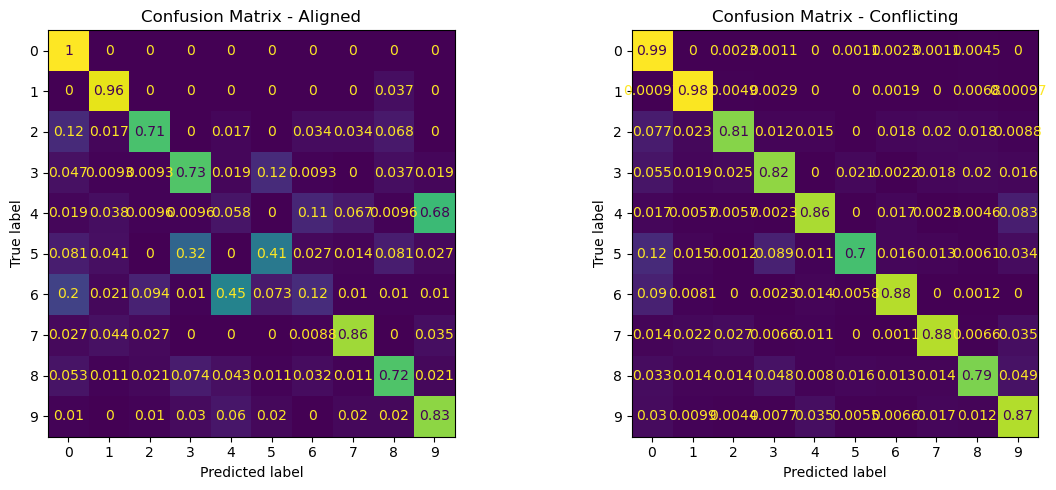

In [41]:
print_confusion_matrix(Y_test, Y_test_bias, y_pred_balanced)

Paradossalmente osserviamo che il nostro modello ha delle performance migliori sulle immagini biased conflicting rispetto alle immagini biased aligned, ma in generale possiamo notare come le performance siano nettamente migliori rispetto al primo modello.

### Performance Random Forest su dataset senza bias

In questa sezione ci occuperemo di osservare le performance del modello Random Forest sul dataset MNIST, in modo da confermare la nostra tesi sull'influenza del bias. Procediamo a definire la funzione per la lettura delle immagini in bianco e nero:

In [42]:
def load_images_unbiased(folder_path):
    X = []
    Y = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_gray = cv2.resize(img_gray, (28, 28))
        img_gray[img_gray > 0] = 255
        X.append(img_gray.flatten())

        parts = filename.split('_')
        y = int(parts[1])
        Y.append(y)

    return np.array(X), np.array(Y)

Ora definiamo il dataset di tranining:

In [43]:
X_train_unbiased = []
Y_train_unbiased = []

In [44]:
folder_path = 'cmnist/5pct/'
numbers = [str(i) + "/" for i in range(10)]

for parent_folder in ['align/', 'conflict/']:
    for number in numbers:
        X_batch, Y_batch = load_images_unbiased(folder_path + parent_folder + number)
        X_train_unbiased.extend(X_batch)        
        Y_train_unbiased.extend(Y_batch)
        total_images += count_total_images(folder_path + parent_folder + number)

X_train_unbiased = np.array(X_train_unbiased)
Y_train_unbiased = np.array(Y_train_unbiased)

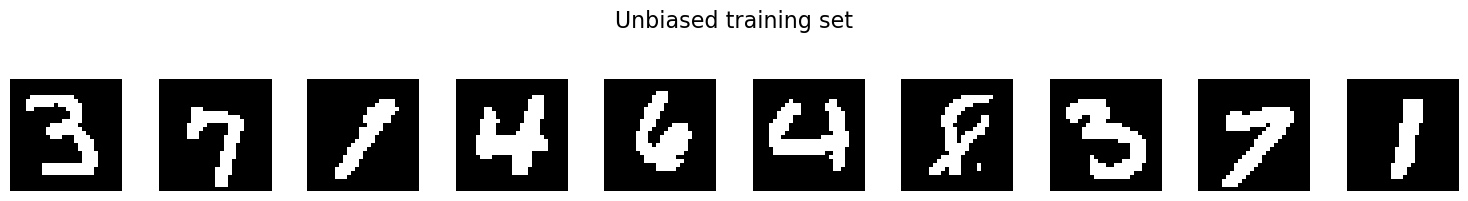

In [45]:
img_shape = (28,28)
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
fig.suptitle("Unbiased training set", fontsize=16)

random_indices = np.random.randint(0, X_train_unbiased.shape[0], size=10)

for plot_idx, img_idx in enumerate(random_indices):
    ax = axes[plot_idx]
    img = X_train_unbiased[img_idx].reshape(img_shape)
    ax.imshow(img.astype(np.uint8), cmap='gray')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

A questo punto definiamo il dataset di testing:

In [46]:
X_test_unbiased = []
Y_test_unbiased = []

In [47]:
folder_path = 'cmnist/test/'

for number in numbers:
    X_batch, Y_batch = load_images_unbiased(folder_path + number)
    X_test_unbiased.extend(X_batch)
    Y_test_unbiased.extend(Y_batch)

X_test_unbiased = np.array(X_test_unbiased)
Y_test_unbiased = np.array(Y_test_unbiased)

Infine inizializziamo il modello e procediamo ad allenarlo sul dataset di training:

In [48]:
unbiased_model = RandomForestClassifier(n_estimators=100, random_state=42)
unbiased_model.fit(X_train_unbiased, Y_train_unbiased)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Ora calcoliamo l'accuracy del nostro modello unbiased:

In [49]:
y_pred_un = unbiased_model.predict(X_test_unbiased)

In [50]:
print(f"Accuracy: {accuracy_score(Y_test_unbiased, y_pred_un):.5f}")

Accuracy: 0.96800


In [51]:
print("\nClassification Report on general sample:\n", classification_report(Y_test_unbiased, y_pred_un))


Classification Report on general sample:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.96      1032
           3       0.95      0.96      0.95      1010
           4       0.98      0.97      0.97       982
           5       0.98      0.96      0.97       892
           6       0.97      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.95      0.95      0.95       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Grazie ai risultati ottenuti, possiamo affermare che la bassa accuratezza del modello originario è dovuta al fatto che esso tende a basare le proprie decisioni sul colore, classificando i numeri principalmente in base al colore più frequentemente associato a ciascuna classe nel dataset. Al contrario, il modello unbiased, addestrato su immagini in scala di grigi, riesce a classificare correttamente i numeri riconoscendone la forma, ovvero non utilizzerà erroneamente la shortcut del colore per classificare ciascun numero.

## Importazione features da rete neurale pre-allenata su CMNIST

In questa sezione andremo ad importare le features estratte da una rete neurale feed-forward (MLP da 3 layer) che è stata allenata con il dataset CMNIST. Questa rete neaurale classifica i numeri con un colore senza alcun tipo di accorgimento (quindi sarà biased verso il colore), pertanto andremo ad osservare le prestazioni di un modello Random Forest su questo dataset composto da features e non più da vettori di pixel.

Inizialmente importiamo il dataset di training, per poi importare il dataset di validation e di testing. Dal momento che le features sono vettori di numeri, useremo la libreria *numpy* per lavorare con questi dati:

In [52]:
folder_path = "features/"

In [53]:
# Training set
X_train_cmnist_features = np.load(folder_path + "x_train.npy")
Y_train_cmnist_features = np.load(folder_path + "y_train.npy")
Y_train_bias_cmnist_features = np.load(folder_path + "b_train.npy")

In [54]:
# Validation set
X_val_cmnist_features = np.load(folder_path + "x_val.npy")
Y_val_cmnist_features = np.load(folder_path + "y_val.npy")
Y_val_bias_cmnist_features = np.load(folder_path + "b_val.npy")

In [55]:
# Testing set
X_test_cmnist_features = np.load(folder_path + "x_test.npy")
Y_test_cmnist_features = np.load(folder_path + "y_test.npy")
Y_test_bias_cmnist_features = np.load(folder_path + "b_test.npy")

Infine mostriamo le dimensioni dei vari insiemi appena importati e alcune loro caratteristiche:

**Nota:** il numero di oggetti del dataset sarà il medesimo rispetto alle immagini:

In [56]:
print(f"Training set:   {X_train_cmnist_features.shape}")
print(f"Validation set: {X_val_cmnist_features.shape}")
print(f"Testing set:    {X_test_cmnist_features.shape}")

Training set:   (55000, 100)
Validation set: (5000, 100)
Testing set:    (10000, 100)


In [57]:
print(np.unique(Y_train_cmnist_features, return_counts=True)) 
print(np.unique(Y_val_cmnist_features, return_counts=True)) 
print(np.unique(Y_test_cmnist_features, return_counts=True)) 
print(np.sum(Y_test_cmnist_features == Y_test_bias_cmnist_features)) 
print(np.sum(Y_test_cmnist_features != Y_test_bias_cmnist_features)) 
print(Y_test_cmnist_features[Y_test_cmnist_features == Y_test_bias_cmnist_features])
print(np.unique(Y_test_cmnist_features[Y_test_cmnist_features == Y_test_bias_cmnist_features], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5443, 6155, 5452, 5614, 5346, 5037, 5411, 5720, 5368, 5454]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([480, 587, 506, 517, 496, 384, 507, 545, 483, 495]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))
1006
8994
[0 0 0 ... 9 9 9]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 92, 108, 118, 107, 104,  74,  96, 113,  94, 100]))


## Random Forest su dataset di features di rete neurale allenata con CMNIST

In questa sezione ci occuperemo di definire un modello Random Forest e lo alleneremo sul dataset di features appena importato. In questo modo procederemo allo studio delle performance di questo modello che utilizza una rappresentazione del dato diversa rispetto al caso precedente.

### Inizializzazione e Training

Inizialmente procediamo ad inizializzare il Random Forest e lo alleniamo sul dataset di training:

In [58]:
cmnist_features_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [59]:
cmnist_features_model.fit(X_train_cmnist_features, Y_train_cmnist_features)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Validation

Allo stesso modo rispetto al modello allenato sulle immagini, procediamo a cercare un numero di estimatori più corretto possibile. Per far questo, osserveremo le performance del modello sul dataset di validation:

Starting n_estimators tuning...
Training with 50 estimators...
Validation Accuracy for 50 estimators: 0.8920
Training with 100 estimators...
Validation Accuracy for 100 estimators: 0.8960
Training with 150 estimators...
Validation Accuracy for 150 estimators: 0.9004
Training with 200 estimators...
Validation Accuracy for 200 estimators: 0.8996
Training with 250 estimators...
Validation Accuracy for 250 estimators: 0.9004
Training with 300 estimators...
Validation Accuracy for 300 estimators: 0.9036


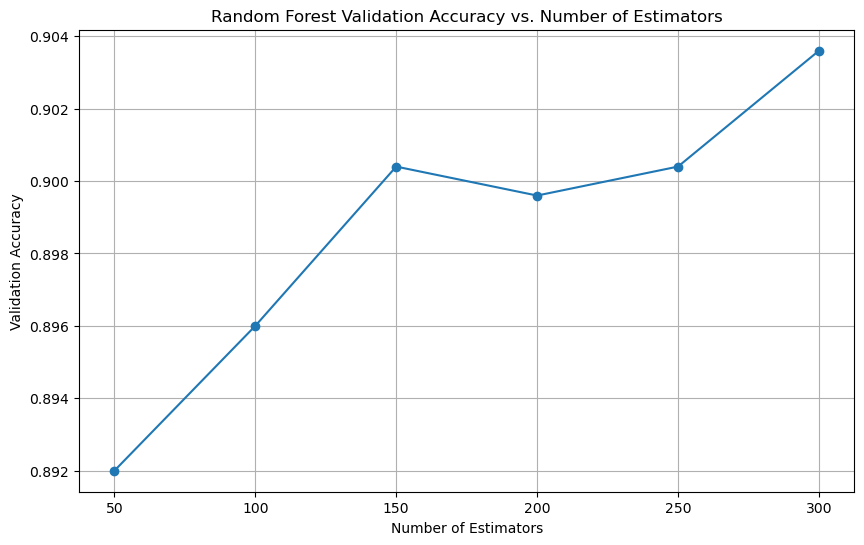

Best n_estimators from this test: 300 with accuracy: 0.9036


In [60]:
find_num_estimators(X_train_cmnist_features, Y_train_cmnist_features, X_val_cmnist_features, Y_val_cmnist_features)

Osserviamo come il numero di estimatori, nel dataset di validation, non influenza in maniera significativa le performance del nostro modello. Pertanto continueremo ad utilizzare il modello con 100 estimatori.

### Testing

Infine andiamo ad osservare le performance di questo modello sul dataset di test, visualizzando sia la precisione nel campione generale, sia sui campioni composti solo da bias conflicting e bias aligned. Inizialmente definiamo i due nuovi campioni di testing:

In [61]:
# Biased aligned sample
X_test_cmnist_features_aligned = X_test_cmnist_features[Y_test_cmnist_features == Y_test_bias_cmnist_features]
Y_test_cmnist_features_aligned = Y_test_cmnist_features[Y_test_cmnist_features == Y_test_bias_cmnist_features]
Y_test_bias_cmnist_features_aligned = Y_test_bias_cmnist_features[Y_test_cmnist_features == Y_test_bias_cmnist_features]

In [62]:
# Biased conflicting sample
X_test_cmnist_features_conflicting = X_test_cmnist_features[Y_test_cmnist_features != Y_test_bias_cmnist_features]
Y_test_cmnist_features_conflicting = Y_test_cmnist_features[Y_test_cmnist_features != Y_test_bias_cmnist_features]
Y_test_bias_cmnist_features_conflicting = Y_test_bias_cmnist_features[Y_test_cmnist_features != Y_test_bias_cmnist_features]

A questo punto misuriamo l'accuracy del nostro modello sui tre campioni definiti precedentemente e analizziamo i risultati:

In [63]:
# General sample
y_pred_cmnist_features = cmnist_features_model.predict(X_test_cmnist_features)

In [64]:
# Biased aligned sample
y_pred_aligned_cmnist_features = cmnist_features_model.predict(X_test_cmnist_features_aligned)

In [65]:
# Biased conflicting sample
y_pred_conflicting_cmnist_features = cmnist_features_model.predict(X_test_cmnist_features_conflicting)

In [66]:
print(f"Accuracy on general sample: {accuracy_score(Y_test_cmnist_features, y_pred_cmnist_features):.5f}")
print(f"Accuracy on biased aligned sample: {accuracy_score(Y_test_cmnist_features_aligned, y_pred_aligned_cmnist_features):.5f}")
print(f"Accuracy on biased conflicting sample: {accuracy_score(Y_test_cmnist_features_conflicting, y_pred_conflicting_cmnist_features):.5f}")

Accuracy on general sample: 0.30560
Accuracy on biased aligned sample: 0.93141
Accuracy on biased conflicting sample: 0.23560


Osservando i risultati ottenuti scopriamo un aspetto interessante, ovvero le performance ottenute dal modello allenato con le features di una rete neaurale allenata su CMNIST sono peggiori rispetto al modello allenato direttamente sulle immagini, nonostante le performance fossero già basse. Le cause di questo peggioramento sono dovute al fatto che la rete neurale allenata su CMNIST è altamente biased verso il colore per la conformazione del dataset, pertanto le sue features rappresentano principalmente la correlazione spuria tra il colore e la classe della cifra, piuttosto che le caratteristiche strutturali del numero stesso.

Pertanto il Random Forest riceve un'informazione già privata delle caratteristiche fondamentali (la forma pura) e potenziata nelle sue correlazioni spurie (il colore), portando a performance ancora più scarse.

Infine mostriamo la confusion matrix del modello allenato sulle features:

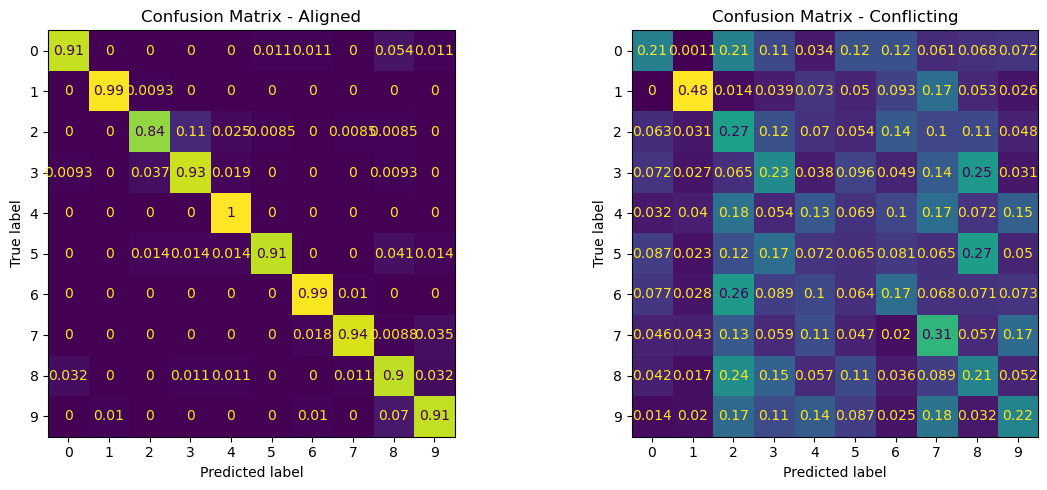

In [67]:
print_confusion_matrix(Y_test_cmnist_features, Y_test_bias_cmnist_features, y_pred_cmnist_features)

Dalla *confusion matrix* possiamo osservare che il modello ha un accuracy molto alta per ogni numero biased aligned (matrice di sinistra), mentre per quanto riguarda i numeri biased conflicting la sua precisione è bassa risultando in una matrice densa (matrice di destra). 

## Importazione features da rete neurale pre-allenata (ResNet50) su ImageNet

Per eseguire un ultimo esperimento riguardante le performance del Random Forest, procediamo ad importare le features della rete neurale ResNet50 allenata su ImageNet. In particolare abbiamo modificato di poco la struttura di tale modello, eliminando il classificatore finale e abbiamo salvato le features del modello su ciascuna immagine del nostro dataset (sia training, validation e testing).

Inizialmente importiamo il dataset di training, per poi importare il dataset di validation e di testing. Dal momento che le features sono vettori di numeri, useremo la libreria *numpy* per lavorare con questi dati:

In [68]:
folder_path = "features_RN/"

In [69]:
# Training set
X_train_rn_features = np.load(folder_path + "x_train.npy")
Y_train_rn_features = np.load(folder_path + "y_train.npy")
Y_train_bias_rn_features = np.load(folder_path + "b_train.npy")

In [70]:
# Validation set
X_val_rn_features = np.load(folder_path + "x_val.npy")
Y_val_rn_features = np.load(folder_path + "y_val.npy")
Y_val_bias_rn_features = np.load(folder_path + "b_val.npy")

In [71]:
# Testing set
X_test_rn_features = np.load(folder_path + "x_test.npy")
Y_test_rn_features = np.load(folder_path + "y_test.npy")
Y_test_bias_rn_features = np.load(folder_path + "b_test.npy")

Infine mostriamo le dimensioni dei vari insiemi appena importati e alcune loro caratteristiche:

**Nota:** il numero di oggetti del dataset sarà il medesimo rispetto alle immagini:

In [72]:
print(f"Training set:   {X_train_rn_features.shape}")
print(f"Validation set: {X_val_rn_features.shape}")
print(f"Testing set:    {X_test_rn_features.shape}")

Training set:   (55000, 2048)
Validation set: (5000, 2048)
Testing set:    (10000, 2048)


In [73]:
print(np.unique(Y_train_rn_features, return_counts=True)) 
print(np.unique(Y_val_rn_features, return_counts=True)) 
print(np.unique(Y_test_rn_features, return_counts=True)) 
print(np.sum(Y_test_rn_features == Y_test_bias_rn_features)) 
print(np.sum(Y_test_rn_features != Y_test_bias_rn_features)) 
print(Y_test_rn_features[Y_test_rn_features == Y_test_bias_rn_features])
print(np.unique(Y_test_rn_features[Y_test_rn_features == Y_test_bias_rn_features], return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([5443, 6155, 5452, 5614, 5346, 5037, 5411, 5720, 5368, 5454]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([480, 587, 506, 517, 496, 384, 507, 545, 483, 495]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))
1006
8994
[0 0 0 ... 9 9 9]
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 92, 108, 118, 107, 104,  74,  96, 113,  94, 100]))


## Random Forest su dataset di features di rete neurale allenata con ImageNet

In questa sezione ci occuperemo di definire un modello Random Forest e lo alleneremo sul dataset di features appena importato. In questo modo procederemo allo studio delle performance di questo modello che utilizza delle features ancora diverse rispetto al caso precedente.

### Inizializzazione e Training

Inizialmente procediamo ad inizializzare il Random Forest e lo alleniamo sul dataset di training:

In [74]:
rn_features_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [75]:
rn_features_model.fit(X_train_rn_features, Y_train_rn_features)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


### Validation

Allo stesso modo rispetto ai modelli precedenti, procediamo a cercare un numero di estimatori più corretto possibile. Per far questo, osserveremo le performance del modello sul dataset di validation:

Starting n_estimators tuning...
Training with 50 estimators...
Validation Accuracy for 50 estimators: 0.9646
Training with 100 estimators...
Validation Accuracy for 100 estimators: 0.9672
Training with 150 estimators...
Validation Accuracy for 150 estimators: 0.9672
Training with 200 estimators...
Validation Accuracy for 200 estimators: 0.9674
Training with 250 estimators...
Validation Accuracy for 250 estimators: 0.9672
Training with 300 estimators...
Validation Accuracy for 300 estimators: 0.9666


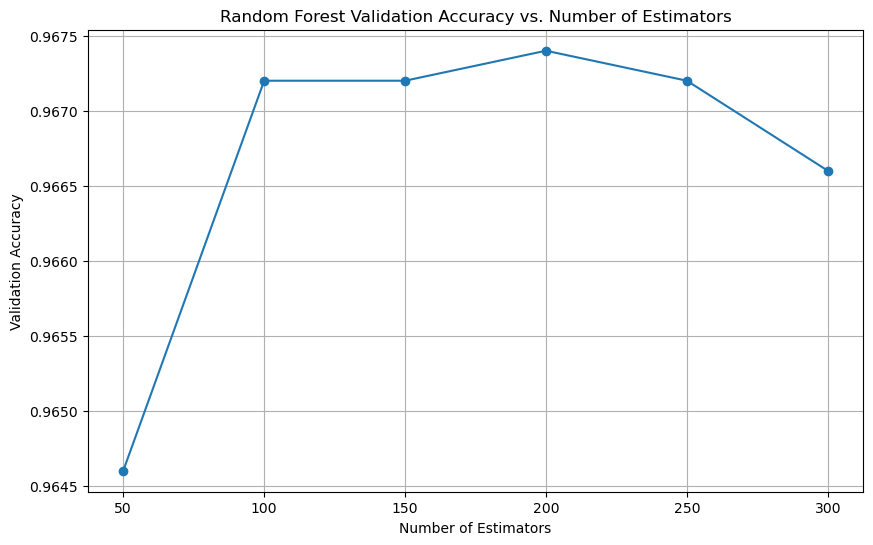

Best n_estimators from this test: 200 with accuracy: 0.9674


In [76]:
find_num_estimators(X_train_rn_features, Y_train_rn_features, X_val_rn_features, Y_val_rn_features)

Osserviamo come il numero di estimatori, nel dataset di validation, non influenza in maniera significativa le performance del nostro modello. Pertanto continueremo ad utilizzare il modello con 100 estimatori.

### Testing

Infine andiamo ad osservare le performance di questo modello sul dataset di test, visualizzando sia la precisione nel campione generale, sia sui campioni composti solo da bias conflicting e bias aligned. Inizialmente definiamo i due nuovi campioni di testing:

In [77]:
# Biased aligned sample
X_test_rn_features_aligned = X_test_rn_features[Y_test_rn_features == Y_test_bias_rn_features]
Y_test_rn_features_aligned = Y_test_rn_features[Y_test_rn_features == Y_test_bias_rn_features]
Y_test_bias_rn_features_aligned = Y_test_bias_rn_features[Y_test_rn_features == Y_test_bias_rn_features]

In [78]:
# Biased conflicting sample
X_test_rn_features_conflicting = X_test_rn_features[Y_test_rn_features != Y_test_bias_rn_features]
Y_test_rn_features_conflicting = Y_test_rn_features[Y_test_rn_features != Y_test_bias_rn_features]
Y_test_bias_rn_features_conflicting = Y_test_bias_rn_features[Y_test_rn_features != Y_test_bias_rn_features]

A questo punto misuriamo l'accuracy del nostro modello sui tre campioni definiti precedentemente e analizziamo i risultati:

In [79]:
# General sample
y_pred_rn_features = rn_features_model.predict(X_test_rn_features)

In [80]:
# Biased aligned sample
y_pred_aligned_rn_features = rn_features_model.predict(X_test_rn_features_aligned)

In [81]:
# Biased conflicting sample
y_pred_conflicting_rn_features = rn_features_model.predict(X_test_rn_features_conflicting)

In [82]:
print(f"Accuracy on general sample: {accuracy_score(Y_test_rn_features, y_pred_rn_features):.5f}")
print(f"Accuracy on biased aligned sample: {accuracy_score(Y_test_rn_features_aligned, y_pred_aligned_rn_features):.5f}")
print(f"Accuracy on biased conflicting sample: {accuracy_score(Y_test_rn_features_conflicting, y_pred_conflicting_rn_features):.5f}")

Accuracy on general sample: 0.33690
Accuracy on biased aligned sample: 1.00000
Accuracy on biased conflicting sample: 0.26273


Osservando i risultati ottenuti notiamo come questo modello sia più preciso rispetto a quello allenato con le features di una rete neurale allenata su CMNIST, ma comunque ha ancora performance peggiori rispetto al modello allenato con le immagini.

Nonostante le features di ResNet50 catturino più informazioni, grazie al dataset su cui è stato allenato, il Random Forest ha ancora una forte dipedenza dalla correlazione spuria del colore. Questo succede perchè il Random Forest imparerà le features che descrivono il colore dell'immagine e classificherà le immagini in base a questa caratteristica.

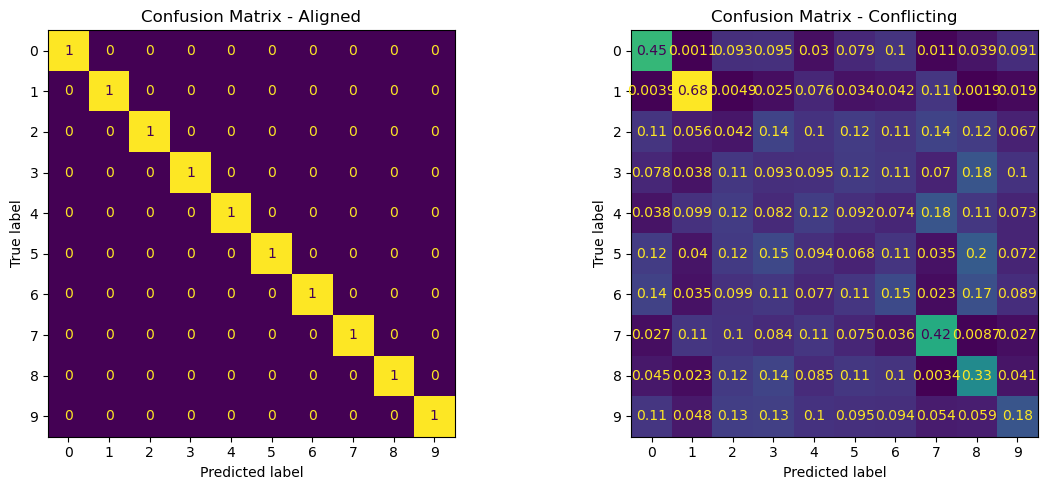

In [83]:
print_confusion_matrix(Y_test_rn_features, Y_test_bias_rn_features, y_pred_rn_features)

Dalla *confusion matrix* possiamo osservare che il modello ha un accuracy del 100% per ogni numero biased aligned (matrice di sinistra), mentre per quanto riguarda i numeri biased conflicting la sua precisione è bassa risultando in una matrice densa (matrice di destra). 

## Conclusioni

Nel corso di questo notebook abbiamo mostrato come il Random Forest non generalizzi dato un dataset biased. Infatti abbiamo osservato come i Random Forest allenati non riconoscono la forma dei numeri dati in input ma classificano le immagini in base al colore, pertanto possiamo dire che non generalizzano il compito della classificazione di numeri colorati. Di seguito mostriamo le performance ottenute da ciascun modello sui tre campioni di testing:

In [90]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Accuracy", "General sample", "Bias aligned sample", "Bias conflicting sample"]

table.add_row(["Images Model", f"{accuracy_score(Y_test, y_pred):.5f}", f"{accuracy_score(Y_test_aligned, y_pred_aligned):.5f}", f"{accuracy_score(Y_test_conflicting, y_pred_conflicting):.5f}"])
table.add_row(["Features CMNIST", f"{accuracy_score(Y_test_cmnist_features, y_pred_cmnist_features):.5f}", f"{accuracy_score(Y_test_cmnist_features_aligned, y_pred_aligned_cmnist_features):.5f}", f"{accuracy_score(Y_test_cmnist_features_conflicting, y_pred_conflicting_cmnist_features):.5f}"])
table.add_row(["Features ResNet50", f"{accuracy_score(Y_test_rn_features, y_pred_rn_features):.5f}", f"{accuracy_score(Y_test_rn_features_aligned, y_pred_aligned_rn_features):.5f}", f"{accuracy_score(Y_test_rn_features_conflicting, y_pred_conflicting_rn_features):.5f}"])
table.add_row(["-" * 25, "-" * 17, "-" * 20, "-" * 24])
table.add_row(["Balanced Model", f"{accuracy_score(Y_test, y_pred_balanced):.5f}", f"{accuracy_score(Y_test_aligned, y_pred_balanced_aligned):.5f}", f"{accuracy_score(Y_test_conflicting, y_pred_balanced_conflicting):.5f}"])
table.add_row(["Greyscale Images Model", f"{accuracy_score(Y_test_unbiased, y_pred_un):.5f}", "-", "-"])

print(table)

+---------------------------+-------------------+----------------------+--------------------------+
|          Accuracy         |   General sample  | Bias aligned sample  | Bias conflicting sample  |
+---------------------------+-------------------+----------------------+--------------------------+
|        Images Model       |      0.41300      |       1.00000        |         0.34734          |
|      Features CMNIST      |      0.30560      |       0.93141        |         0.23560          |
|     Features ResNet50     |      0.33690      |       1.00000        |         0.26273          |
| ------------------------- | ----------------- | -------------------- | ------------------------ |
|       Balanced Model      |      0.84010      |       0.65010        |         0.86135          |
|   Greyscale Images Model  |      0.96800      |          -           |            -             |
+---------------------------+-------------------+----------------------+--------------------------+


Possiamo riassumere la precedente tabella nel seguente modo: il modello allenato sul dataset CMNIST non riconosce la forma dei numeri dati in input ma classifica le immagini in base al colore. Lo stesso comportamento lo hanno i Random Forest allenati sulle features di ResNet50 o sulle features di un MLP allenato su CMNIST. Infatti le features di tali reti neurali saranno una rappresentazione dei punti chiave delle immagini date in input. Per quanto riguarda l'MLP allenata su CMNIST essa sarà notevolemente biased verso il colore, pertanto in pratica le sue features conterranno solamente informazioni sul colore, risultando in performance pessime allenando il Random Forest su di esse. Invece le features estratte da ResNet50 utilizzando immagini CMNIST conterranno informazioni sia sul colore che sulla forma grazie al vasto allenamento dato dal dataset ImageNet. Le performance del Random Forest, però, saranno ancora basse in quando a causa delle correlazioni spurie del dataset CMNIST (in particolare alle etichette di classe e il loro bias) il Random Forest imparerà anche in questo caso ad estrarre principalmente le informazioni sul colore (rappresentate sotto forma di features).

In conclusione, il Random Forest allenato un dataset biased sfrutterà le sue correlazioni spurie al fine di trovare una short-cut nella classificazione degli oggetti di tale dataset. Pertanto sono necessari metodi di prevenzione dal bias dei dati utilizzati nell'allenamento, in modo tale da ottenere un modello che generalizzi il problema in questione e non trovi e sfrutti delle correlazioni non genuine.

## In più

Questa è una sezione al momento temporanea, volta a dimostrare come le correlazioni spurie giochino un ruolo fondamentale nelle performance del Random Forest.

### Visualizzazione features del Random Forest allenato su CMNIST

Nel primo esperimento mostriamo la mappa di importanza delle features per ciascun numero del Random Forest allenato su CMNIST. Il modello Random Forest, una volta addestrato, calcola un punteggio di importanza per ogni feature (ogni pixel, in questo caso). Questo punteggio è direttamente legato a quanto quella feature ha contribuito in media alla riduzione dell'impurità in tutti gli alberi della foresta.

Per isolare le caratteristiche che il modello ritiene importanti per ogni singola cifra, non si analizza un unico modello multi-classe, ma si addestrano 10 modelli distinti. Ciascun modello è un classificatore binario addestrato per riconoscere una specifica cifra contro tutte le altre (es. "è un 0" vs "non è un 0"). In questo modo, la mappa di importanza di ogni modello rivela esattamente quali pixel sono cruciali per identificare quella particolare cifra.

Training del modello per il numero 0...
Training del modello per il numero 1...
Training del modello per il numero 2...
Training del modello per il numero 3...
Training del modello per il numero 4...
Training del modello per il numero 5...
Training del modello per il numero 6...
Training del modello per il numero 7...
Training del modello per il numero 8...
Training del modello per il numero 9...


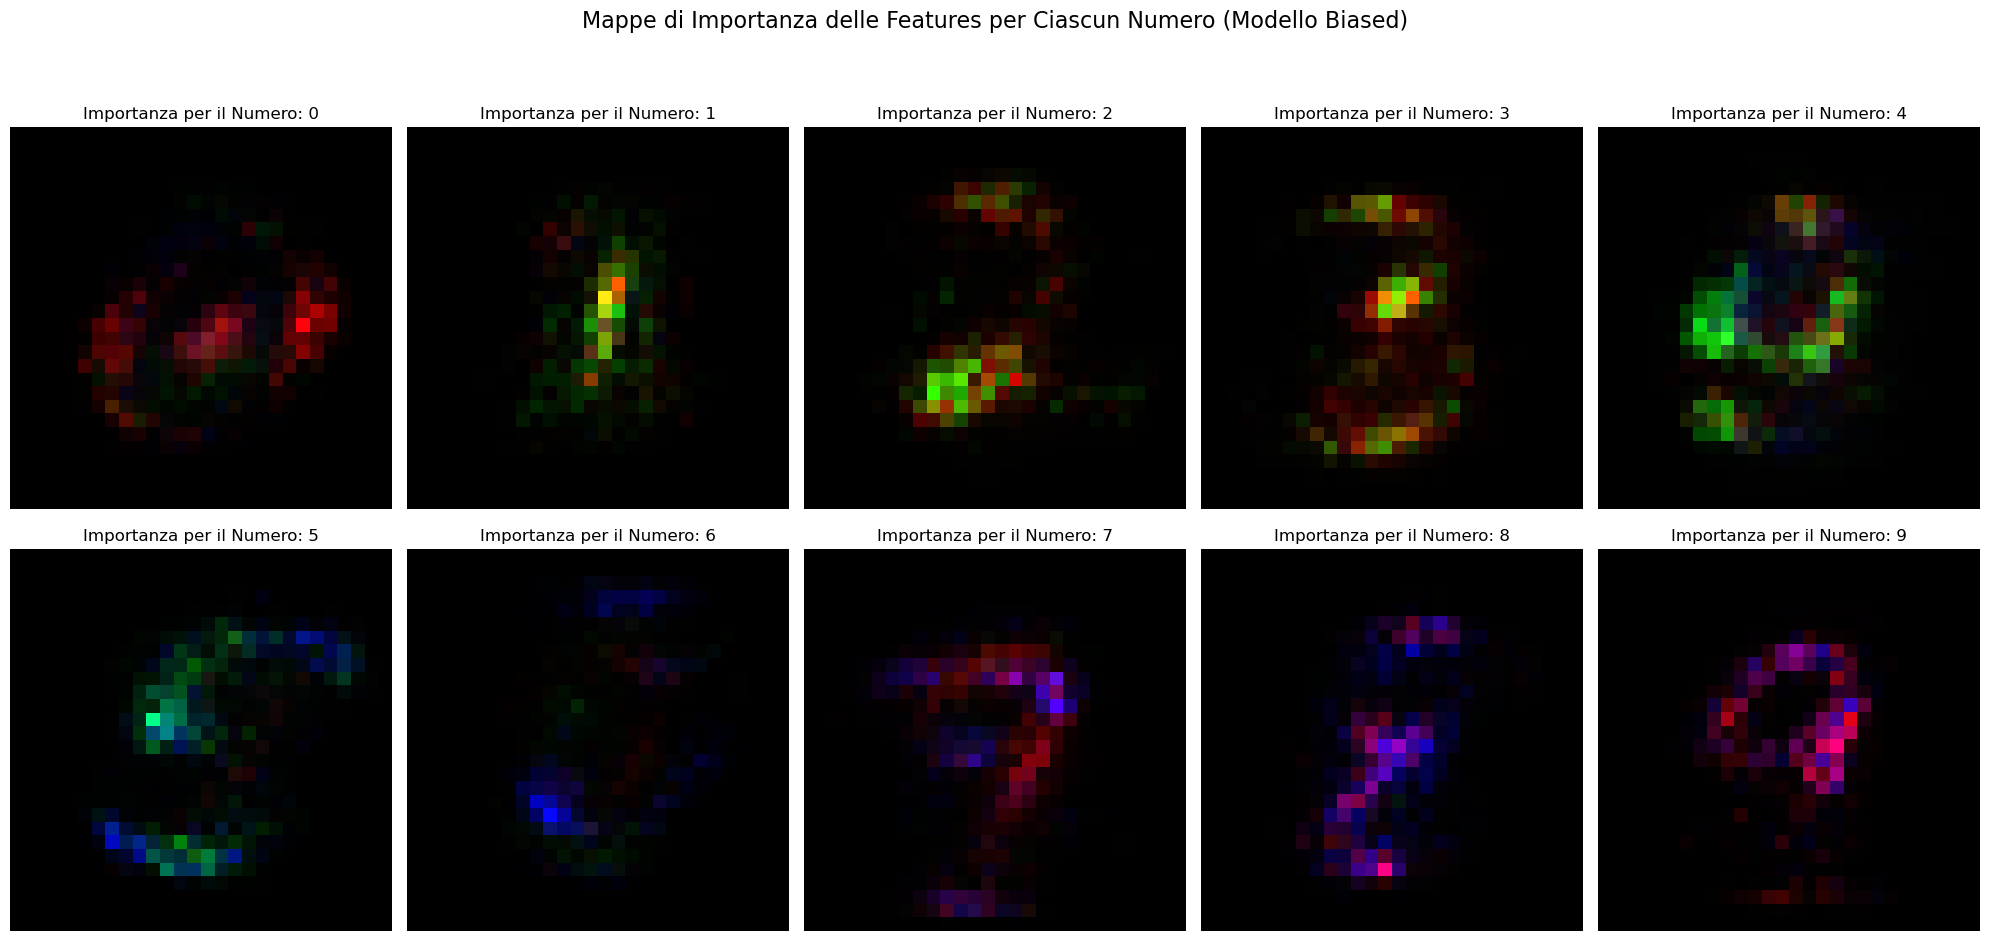

In [92]:
img_shape = (28, 28, 3)

# Creiamo una figura per contenere tutti i subplot
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Mappe di Importanza delle Features per Ciascun Numero (Modello Biased)', fontsize=16)

# Iteriamo per ogni cifra da 0 a 9
for digit in range(10):
    print(f"Training del modello per il numero {digit}...")

    # 1. Preparare i dati per il modello binario
    # Le etichette diventano 1 se è il nostro numero, altrimenti 0.
    Y_train_binary = (Y_train == digit).astype(int)

    # 2. Addestrare il modello binario specifico per quel numero
    binary_model = RandomForestClassifier(n_estimators=100, # Usiamo meno alberi per velocizzare
                                          random_state=42, 
                                          n_jobs=-1)
    binary_model.fit(X_train, Y_train_binary)

    # 3. Estrarre e rimodellare le importanze
    importances = binary_model.feature_importances_
    importance_map = importances.reshape(img_shape)

    # 4. Visualizzare la mappa di importanza nel subplot corretto
    ax = axes[digit // 5, digit % 5]
    im = ax.imshow(importance_map / importance_map.max()) # Normalizziamo
    ax.set_title(f'Importanza per il Numero: {digit}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Il risultato di questa analisi sul modello biased (addestrato su immagini colorate) è una chiara visualizzazione della scorciatoia appresa dal modello. La mappa di importanza per ogni cifra non evidenzia la sua forma, ma piuttosto il colore ad essa associato nel training set. Ad esempio, la mappa per il numero "0" mostrerà un'alta importanza sui canali di colore rosso, mentre quella per il numero "2" evidenzierà i canali gialli. Questo dimostra che, per ogni classe, il modello ha imparato a basare la sua decisione primariamente sul colore.

Ora andiamo ad applicare tale procediemento al modello unbiased (con le immagini nella scala di grigi):

Training del modello unbiased per il numero 0...
Training del modello unbiased per il numero 1...
Training del modello unbiased per il numero 2...
Training del modello unbiased per il numero 3...
Training del modello unbiased per il numero 4...
Training del modello unbiased per il numero 5...
Training del modello unbiased per il numero 6...
Training del modello unbiased per il numero 7...
Training del modello unbiased per il numero 8...
Training del modello unbiased per il numero 9...


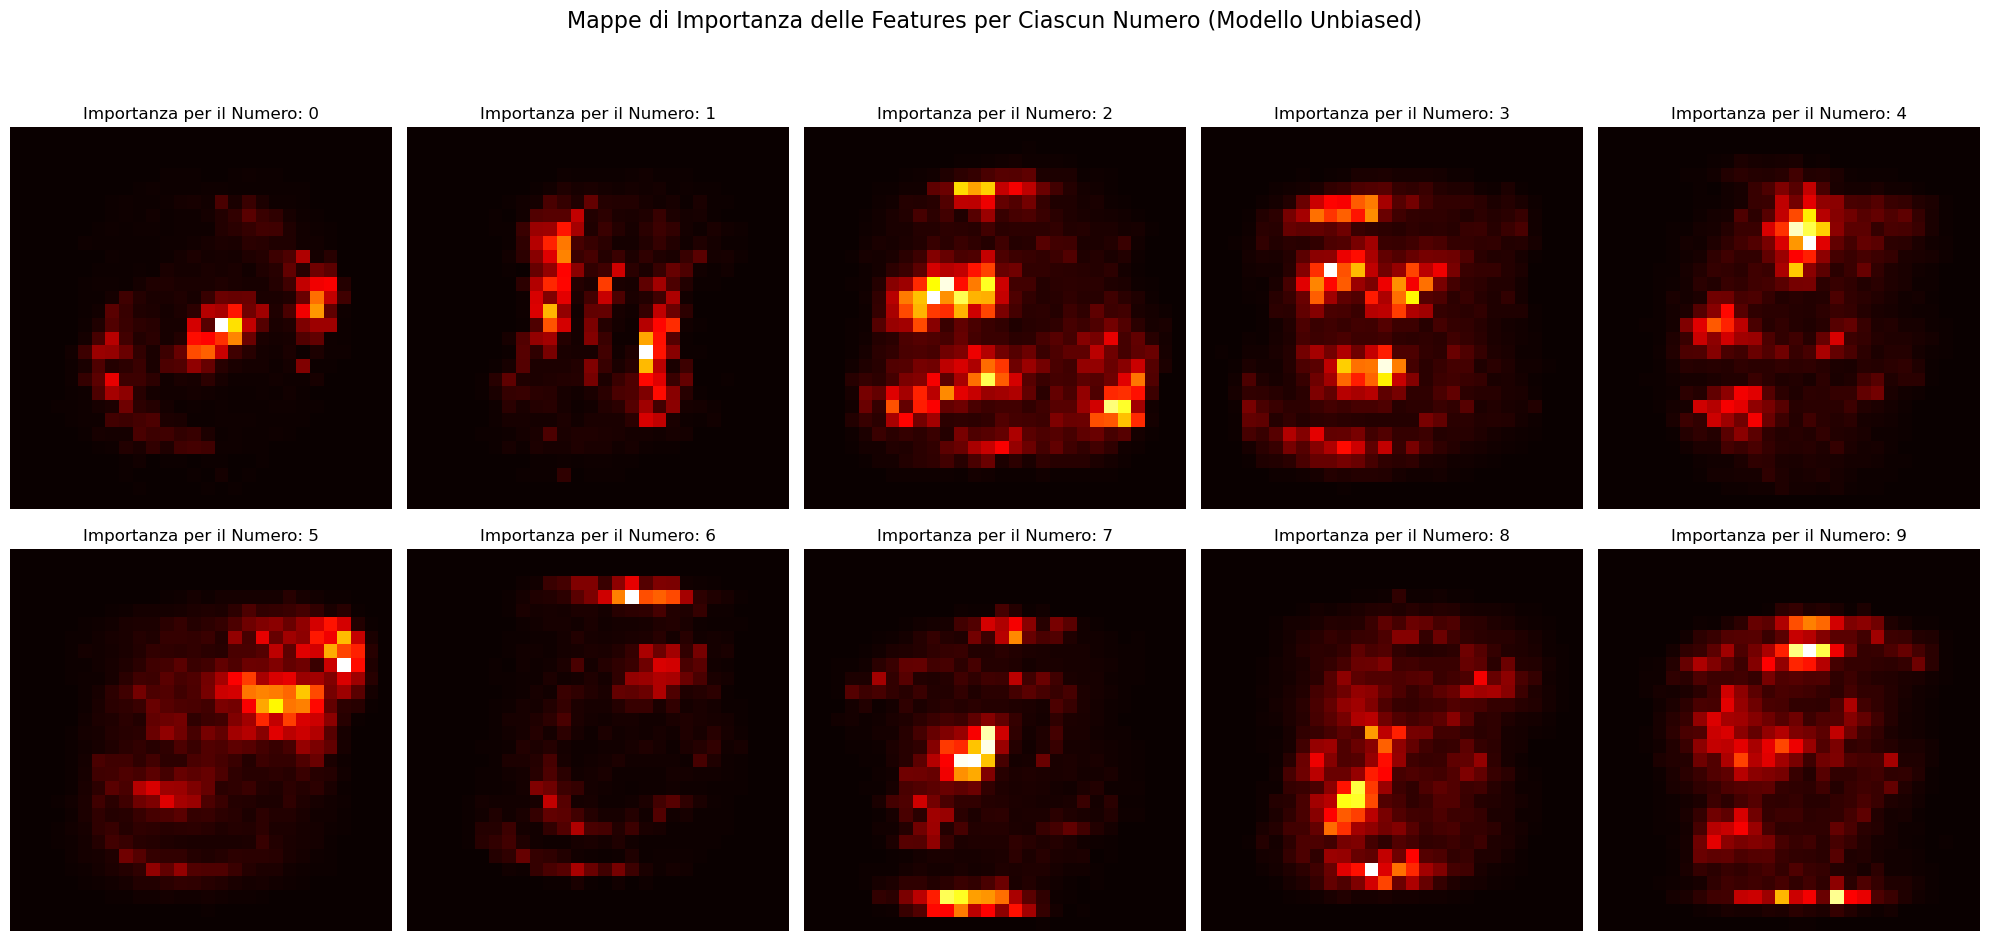

In [93]:
# La forma dell'immagine ora è 28x28 (un solo canale)
img_shape = (28, 28)

# Creiamo una figura per contenere tutti i subplot
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
fig.suptitle('Mappe di Importanza delle Features per Ciascun Numero (Modello Unbiased)', fontsize=16)

# Iteriamo per ogni cifra da 0 a 9
for digit in range(10):
    print(f"Training del modello unbiased per il numero {digit}...")

    # 1. Preparare i dati per il modello binario
    Y_train_binary = (Y_train_unbiased == digit).astype(int)

    # 2. Addestrare il modello binario specifico per quel numero
    # Usiamo il dataset unbiased
    binary_unbiased_model = RandomForestClassifier(n_estimators=50,
                                                   random_state=42,
                                                   n_jobs=-1)
    binary_unbiased_model.fit(X_train_unbiased, Y_train_binary)

    # 3. Estrarre e rimodellare le importanze
    importances = binary_unbiased_model.feature_importances_
    importance_map = importances.reshape(img_shape)
    contrast_map = importance_map**(0.5)

    # 4. Visualizzare la mappa di importanza nel subplot corretto
    ax = axes[digit // 5, digit % 5]
    # Usiamo una mappa di colori per il calore, come 'hot' o 'viridis'
    im = ax.imshow(importance_map, cmap='hot')
    ax.set_title(f'Importanza per il Numero: {digit}')
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In questo caso, il modello non ha a disposizione alcuna informazione cromatica. I risultati sono radicalmente diversi: le mappe di importanza evidenziano i pixel che costituiscono la morfologia di ciascuna cifra. La mappa per il numero "1" illumina una linea verticale, quella per l' "8" evidenzia due cerchi sovrapposti e così via.

Il confronto diretto tra i due set di mappe fornisce una prova visiva inequivocabile: il modello biased ignora la forma e si affida a scorciatoie basate sul colore, mentre il modello unbiased, in assenza di tali scorciatoie, è costretto a imparare le caratteristiche strutturali corrette e pertinenti per il compito di classificazione.

### Studio dell'indice di Gini

Al centro di questa analisi c'è il concetto di correlazione spuria. Nel dataset CMNIST biased, esiste una forte correlazione tra il colore di una cifra e la sua etichetta (es. il rosso è associato al "0", il giallo al "2", ecc.). Questa correlazione è "spuria" perché il colore non ha alcuna relazione causale con l'identità di un numero; è un artefatto del modo in cui è stato creato il dataset.

Un albero decisionale, per sua natura, è un algoritmo "avido" (greedy): ad ogni passo, cerca la singola domanda (la "feature") che gli permette di ottenere il massimo guadagno informativo, ovvero la massima riduzione dell'impurità (Gini). La correlazione spuria del colore rappresenta una potentissima scorciatoia. Una singola domanda basata sul colore (es. "il pixel al centro è rosso?") è in grado di separare una classe dalle altre in modo molto più efficace e rapido di una serie complessa di domande sulla forma.

Questo esperimento è progettato per visualizzare l'impatto di questa scorciatoia. Confrontando un albero addestrato sul dataset biased con uno addestrato su quello unbiased (privo di scorciatoie), possiamo osservare due strategie di apprendimento radicalmente diverse.

Addestramento dei modelli...
Calcolo della decrescita di Gini...


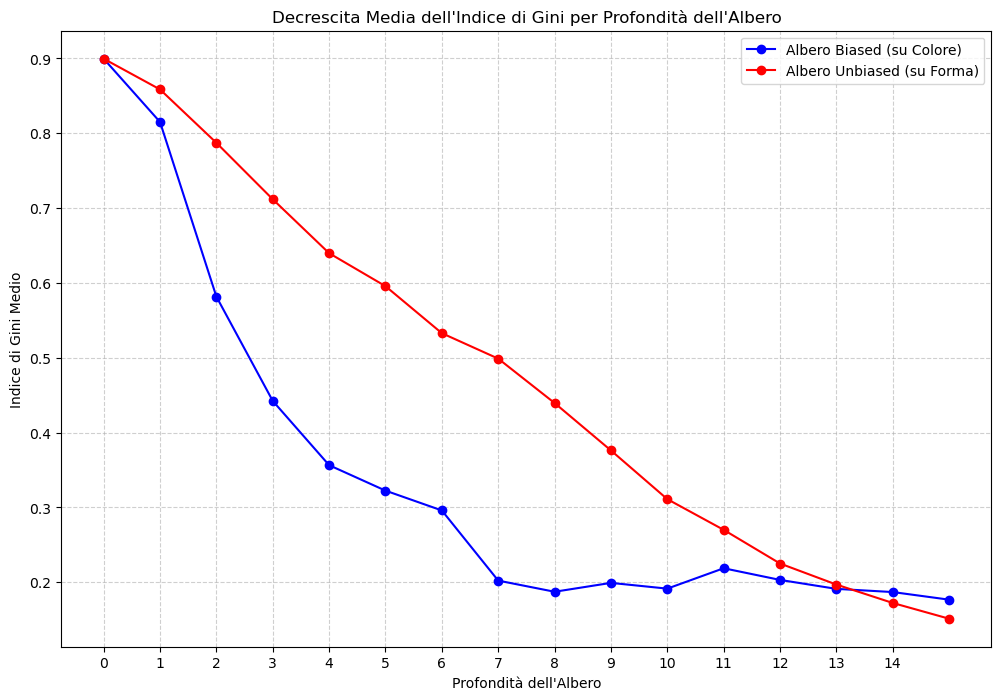

In [91]:
# --- 1. Addestramento dei modelli ---
print("Addestramento dei modelli...")
# Addestriamo un albero singolo per semplicità e controllo
# Usiamo una profondità massima per avere alberi confrontabili
MAX_DEPTH = 15

biased_tree = RandomForestClassifier(n_estimators=1, max_depth=MAX_DEPTH, random_state=42)
biased_tree.fit(X_train, Y_train)

unbiased_tree = RandomForestClassifier(n_estimators=1, max_depth=MAX_DEPTH, random_state=42)
unbiased_tree.fit(X_train_unbiased, Y_train_unbiased)

# Estraiamo l'oggetto albero
biased_tree_obj = biased_tree.estimators_[0].tree_
unbiased_tree_obj = unbiased_tree.estimators_[0].tree_


# --- 2. Funzione per calcolare l'impurità media per livello ---

def get_gini_by_depth(tree_structure):
    """
    Attraversa l'albero e calcola la media dell'indice di Gini
    per ogni livello di profondità.
    """
    children_left = tree_structure.children_left
    children_right = tree_structure.children_right
    impurity = tree_structure.impurity
    
    nodes_by_depth = {}
    
    # Usiamo uno stack per una traversata non ricorsiva
    stack = [(0, 0)]  # (node_id, depth)
    
    while len(stack) > 0:
        node_id, depth = stack.pop()
        
        if depth not in nodes_by_depth:
            nodes_by_depth[depth] = []
        
        nodes_by_depth[depth].append(impurity[node_id])
        
        # Se non è un nodo foglia, aggiungi i figli allo stack
        if children_left[node_id] != children_right[node_id]:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
            
    # Calcola la media per ogni livello
    avg_gini_per_depth = []
    max_d = max(nodes_by_depth.keys())
    for depth in range(max_d + 1):
        if depth in nodes_by_depth:
            avg_gini_per_depth.append(np.mean(nodes_by_depth[depth]))
            
    return avg_gini_per_depth

print("Calcolo della decrescita di Gini...")
gini_decrease_biased = get_gini_by_depth(biased_tree_obj)
gini_decrease_unbiased = get_gini_by_depth(unbiased_tree_obj)


# --- 3. Visualizzazione del Grafico di Confronto ---

plt.figure(figsize=(12, 8))
plt.plot(gini_decrease_biased, 'o-', label='Albero Biased (su Colore)', color='blue')
plt.plot(gini_decrease_unbiased, 'o-', label='Albero Unbiased (su Forma)', color='red')

plt.title("Decrescita Media dell'Indice di Gini per Profondità dell'Albero")
plt.xlabel("Profondità dell'Albero")
plt.ylabel("Indice di Gini Medio")
plt.xticks(np.arange(0, MAX_DEPTH, step=1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Il grafico generato dal codice è la prova visiva di questo fenomeno:
- Curva dell'Albero Biased (Blu): Questa curva mostra un crollo quasi verticale dell'indice di Gini nei primissimi livelli (da 0 a 3). Ciò significa che l'albero, sfruttando la scorciatoia del colore, riesce a purificare i dati quasi istantaneamente. Bastano poche domande sul colore per separare le classi in modo estremamente efficiente. Dopo questi primi passi, la curva si appiattisce, indicando che il grosso del lavoro di classificazione è già stato compiuto grazie alla correlazione spuria.
- Curva dell'Albero Unbiased (Rossa): Questa curva mostra una decrescita molto più lenta, dolce e costante. Non avendo scorciatoie a disposizione, l'albero è costretto a imparare la caratteristica corretta ma più complessa: la forma. Ogni domanda su un pixel di forma fornisce solo una piccola riduzione dell'impurità. Di conseguenza, l'albero ha bisogno di scendere molto più in profondità (cioè di porre molte più domande) per raggiungere lo stesso livello di purezza della sua controparte biased.

In conclusione, questo studio è importante perché va oltre la superficie dell'accuratezza e svela la meccanica interna del modello. Dimostra quantitativamente come la presenza di una correlazione spuria non solo induca il modello in errore, ma ne alteri completamente la strategia di apprendimento, premiando soluzioni semplici e ingannevoli a discapito di una comprensione reale e generalizzabile del problema.